![datiaperti logo](images/datiaperti_small.png)

# Geospatial Data Analysis
Geospatial data such as satellite imagery or elevation model are represented as one or more matrices of values. For example an image is usually represented as three matrices (bands) of values in the Red, Blue or Green colors. Each pixel of the image is represented by three RGB values. Satellite imagery may have more than three bands depending on the type of sensor used in the acquisition. Digital elevetion models (DEMs) and land cover models are represented as single band raster data. In this section we'll see how raster data can be read, processed and written in a file.

## Raster Data
The upper-left corner of an image represents the origin (0, 0). The x axis goes from the origin to the left while the y axis goes from the origin to the bottom of the image. We use the [GDAL Python binding](https://gdal.org/tutorials/raster_api_tut.html)  to read and write GeoTIFF files that contain the raster data and metadata. We use the [PIL](https://pillow.readthedocs.io/en/stable/index.html) Python package to render the images and Matplotlib to visualize them in the notebook.

In [1]:
import os
import shutil
import glob
import numpy as np
import math
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print("GDAL version: %s"%gdal.__version__)

GDAL version: 3.5.1


We want to stack three raster images, acquired by a Landsat satellite, into a GeoTIFF file, a lossless format, so that they can be used as RGB bands. Let's have a look at one of them

TIFF (8849, 8023) L


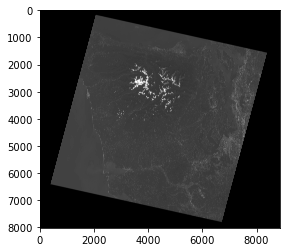

In [2]:
path = 'data/raster/Landsat/Washington/'
band1_fn = path + 'p047r027_7t20000730_z10_nn10.tif'
band2_fn = path + 'p047r027_7t20000730_z10_nn20.tif'
band3_fn = path + 'p047r027_7t20000730_z10_nn30.tif'
im_band1 = Image.open(band1_fn)
print(im_band1.format, im_band1.size, im_band1.mode)
plt.imshow(im_band1, cmap='gray')

The image files are provided in GeoTIFF format with one single band so we extract information from their metadata such as the image size for each dimension, the spatial reference system and the coordinates of the origin. We use the GDAL library to open the raster file and look at its properties such as the coordinate reference system, its origin and pixel resolution. The CRS of each image is projected using the Transverse Mercator projection. The pixel resolution is 28.5 meters and the (y) origin, on the upper left corner, is at 5369.85 km from the equator.

In [21]:
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)
in_band.XSize, in_band.YSize, in_band.DataType, in_ds.GetProjection()

(8849,
 8023,
 1,
 'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

In [22]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = in_ds.GetGeoTransform()
print('x_origin: {}, y_origin: {}, row_rotation: {}, pixel resolution: {}'.format(x_origin, y_origin, row_rotation, x_pixel_resolution))

x_origin: 343724.25, y_origin: 5369585.25, row_rotation: 0.0, pixel resolution: 28.5


We create a new GeoTIFF file with three bands of the same size and spatial reference system as the source images

In [23]:
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create(path + 'nat_color.tif', in_band.XSize, in_band.YSize, 3, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())

0

We copy the raster data of the 1st Landsat image (blue band) into the 3rd band of the created GeoTIFF file

In [24]:
in_data = in_band.ReadAsArray()
out_band = out_ds.GetRasterBand(3)
out_band.WriteArray(in_data)

0

We open the 2nd Landsat image (green band) and we put the raster data into the 2nd band

In [25]:
in_ds = gdal.Open(band2_fn)
out_band = out_ds.GetRasterBand(2)
out_band.WriteArray(in_ds.ReadAsArray())

0

Finally we put the 3rd Landsat image (red band) into the 1st band

In [26]:
in_ds = gdal.Open(band3_fn)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(in_ds.ReadAsArray())

0

we write the data on disk. If the file is a new one we have to close the data source as well.

In [27]:
out_ds.FlushCache() 

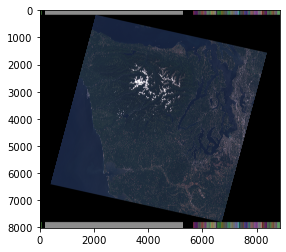

In [28]:
im_natcol = Image.open(path + 'nat_color.tif')
plt.imshow(im_natcol)

we compute some statistical values for each band: min, max, mean, and standard deviation. We create also some overview layers for each band to be visualized at different zoom levels.

In [49]:
for i in range(1, 4):
    stats = out_ds.GetRasterBand(i).ComputeStatistics(True)
    if i == 1:
        band = 'R' 
    if i == 2:
        band = 'G' 
    if i == 3:
        band = 'B' 
    min = stats[0] 
    max = stats[1]
    mean = stats[2]
    std = stats[3]
    print('Band: {0:s}, Min = {1:f}, Max = {2:f}, Mean = {3:f}, Std. = {4:f}.'.format(band, min, max, mean, std))

Band: R, Min = 0.000000, Max = 255.000000, Mean = 21.965179, Std. = 21.780161.
Band: G, Min = 0.000000, Max = 255.000000, Mean = 28.356135, Std. = 25.545738.
Band: B, Min = 0.000000, Max = 255.000000, Mean = 38.780589, Std. = 33.435322.


In [50]:
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32])

0

When we are done we can close the file

In [51]:
del out_ds

### Raster data subsetting
Satellite imagery cover large areas of the Earth surface. If we are interested only in a subset of such areas it is worthwhile to copy that subset in a new file in order to reduce the processing time.  

Let's say we are only interested in the area covered by the snow in the Landsat band1 imagery we have used in the previous section. In order to select an area inside the original image we have to apply an affine transformation that copies the pixels in the original image to the new one keeping the same metrics (i.e. distance). The affine transformation we are going to define is more precisely a translation, that is we will not apply any rotation.

In [52]:
band1_ds = gdal.Open(band1_fn)
x_offset, x_resolution, x_rotation, y_offset, y_rotation, y_resolution = band1_ds.GetGeoTransform()
print('x_offset: {} m, y_offset: {} m, x_resolution: {} m, y_resolution: {} m'.format(x_offset, y_offset, x_resolution, abs(y_resolution)))

x_offset: 343724.25 m, y_offset: 5369585.25 m, x_resolution: 28.5 m, y_resolution: 28.5 m


From the number of rows and columns and from the x and y pixel resolution we can compute the size of the area covered by the image

In [59]:
band1 = band1_ds.GetRasterBand(1)
print(band1.XSize, band1.YSize)
x_length = band1.XSize * x_resolution
y_length = band1.YSize * y_resolution
print('x length: {:.1f} km, y length: {:.1f} km'.format(x_length / 1000, abs(y_length) / 1000))

8849 8023
x length: 252.2 km, y length: 228.7 km


We want to move the offset of the subset image 90 km to the east and 60 km to the south. We need to compute the transformation that will be used to create the subset image. The spatial resolution for both x and y dimension will stay the same.

In [56]:
x_delta = 90000
y_delta = -60000
x_subset_offset = x_offset + x_delta # meter
y_subset_offset = y_offset + y_delta # meters
subset_transform = [x_subset_offset, x_resolution, x_rotation, y_subset_offset, y_rotation, y_resolution]
subset_transform

[433724.25, 28.5, 0.0, 5309585.25, 0.0, -28.5]

Then we want the length of the subset image to be 30 km to the east and 30 km to the south

In [53]:
x_subset_length = 30000 # meters
y_subset_length = 30000 # meters

We need to compute the number of pixels that corresponds to the size of the image for each direction

In [54]:
x_window_length = round(x_subset_length / x_resolution)
y_window_length = round(y_subset_length / abs(y_resolution))
x_window_length, y_window_length

(1053, 1053)

We also need to compute the pixel indexes that corresponds to the new offset 

In [57]:
x_window_start = round(x_delta / x_resolution)
y_window_start = round(abs(y_delta / y_resolution))
x_window_start, y_window_start

(3158, 2105)

We create a new GeoTiff file for the image subset, with one band and the size we want. We also set the offset of the subset image in the file metadata. We will use the same spatial reference system and the same spatial resolution in both x and y direction.

In [60]:
gtiff_driver = gdal.GetDriverByName('GTiff')
subset_ds = gtiff_driver.Create(path + 'subset.tif', xsize=x_window_length, ysize=y_window_length, bands=1, eType=band1.DataType)
subset_ds.SetProjection(band1_ds.GetProjection())
subset_ds.SetGeoTransform(subset_transform)
subset_band = subset_ds.GetRasterBand(1)

In [61]:
data = band1.ReadAsArray()
rows_start = y_window_start
rows_end = y_window_start + y_window_length
cols_start = x_window_start
cols_end = x_window_start + x_window_length
subset_data = data[rows_start:rows_end, cols_start:cols_end]
print(np.shape(subset_data))
subset_band.WriteArray(subset_data)
subset_ds.FlushCache() 
subset_ds = None
band1_ds = None

(1053, 1053)


Now we can plot the subset image

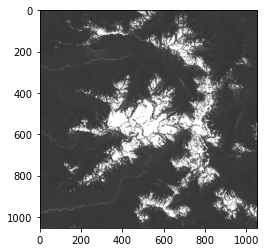

In [62]:
subset_img = Image.open(path + 'subset.tif')
plt.imshow(subset_img, cmap='gray')

### Resampling to smaller pixels (larger dimensions)
We read the input data into a 2D array and we write the data into an array whose dimensions are twice the original and the pixel resolution is half the original. The resampling to a smaller pixel resolution is done automatically by copyng the value of each pixel to 4 pixels in the new image.

In [74]:
path = 'data/raster/Landsat/Washington/'
band1_fn = path + 'subset.tif'
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)
out_rows = in_band.YSize * 2
out_columns = in_band.XSize * 2
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create(path + 'subset_resampled_smaller_pixel.tif', out_columns, out_rows)

Here we apply a transformation for which the pixel width in the west-east direction and in the north-south direction is halved.

In [75]:
out_ds.SetProjection(in_ds.GetProjection())
geotransform = list(in_ds.GetGeoTransform())
geotransform [1] /= 2  # west-east pixel resolution (or pixel width)
geotransform [5] /= 2  # north-south pixel resolution
out_ds.SetGeoTransform(geotransform)
data = in_band.ReadAsArray(buf_xsize=out_columns, buf_ysize=out_rows)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(data)
out_band.FlushCache()
out_band.ComputeStatistics(False)
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32, 64])
del out_ds

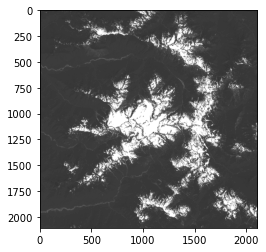

In [76]:
subset_img = Image.open(path + 'subset_resampled_smaller_pixel.tif')
plt.imshow(subset_img, cmap='gray')

### Resampling to larger pixels (smaller dimensions)
We read the input data into a 2D array and we write the data into an array whose dimensions are half the original and the pixel resolution is twice the original. The resampling to a larger pixel resolution is done automatically by computing the nearest neighbors.

In [71]:
path = 'data/raster/Landsat/Washington/'
band1_fn = path + 'subset.tif'
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)
out_rows = round(in_band.YSize / 2)
out_columns = round(in_band.XSize / 2)
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create(path + 'subset_resampled_larger_pixel.tif', out_columns, out_rows)

Here we apply a transformation for which the pixel width in the west-east direction and in the north-south direction is doubled.

In [72]:
out_ds.SetProjection(in_ds.GetProjection())
geotransform = list(in_ds.GetGeoTransform())
geotransform [1] *= 2  # west-east pixel resolution (or pixel width)
geotransform [5] *= 2  # north-south pixel resolution
out_ds.SetGeoTransform(geotransform)
data = in_band.ReadAsArray(buf_xsize=out_columns, buf_ysize=out_rows)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(data)
out_band.FlushCache()
out_band.ComputeStatistics(False)
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32, 64])
del out_ds

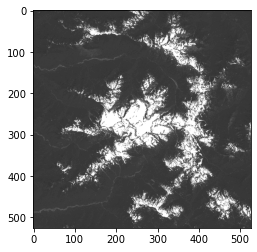

In [73]:
subset_img = Image.open(path + 'subset_resampled_larger_pixel.tif')
plt.imshow(subset_img, cmap='gray')

### Georeferencing
We want to assign a spatial reference system to an image. In order to map a pixel in the image to a place we have to apply a transformation from the image coordinate space to a georeferenced coordinate space (see ref. 1). For this task we use some ground control points. The procedure is explained in the [QGIS User Guide](https://docs.qgis.org/3.16/en/docs/user_manual/working_with_raster/georeferencer.html). As a simple example we will refer an image to the WGS84 geographic (unprojected) reference system. The example image does not have any spatial reference system so it cannot be overlaid onto a map, for example using QGIS, because the software doesn't know where it should be put.

In [3]:
orig_fn = r'data\raster\Utah\cache_no_gcp.tif'
fn = r'data\raster\Utah\cache.tif'
shutil.copy(orig_fn, fn)
ds = gdal.Open(fn, gdal.GA_Update)
sr = osr.SpatialReference()
sr.SetWellKnownGeogCS('WGS84')

0

We need at least three ground control points: we will use four, with their coordinates referenced to WGS84. For each point we need its x, y, and z coordinates and the row and column of the pixel in the image that refers to the ground point. The GDAL library uses the GCPs to compute the coefficients of the affine transformation that will map a pixel to a point in the spatial reference system.

$$ E = a_{11}x + a_{12}y + t_E $$
$$ N = a_{21}x + a_{22}y + t_N $$

Here x and y represent the pixel indexes, E and N are the spatial coordinates, often referred to as easting and northing. The coefficients $a_{ij}$ represent rotation and scale, $t_E$ and $t_N$ represent a translation. Each ground control point defines two linear equations of 6 unknown coefficients so we need at least three GCP to solve the linear system of 6 equations in 6 unknown coefficients. Since the GCPs may not be precise it is usually recommended to use more than three GCPs and compute the best approximation to the real value by minimizing the root mean square errors (RMSE) between the real spatial coordinates and the coordinates computed using the affine transformation.    

In [4]:
gcps = [gdal.GCP(-111.931075, 41.745836, 0, 1078, 648),
        gdal.GCP(-111.901655, 41.749269, 0, 3531, 295),
        gdal.GCP(-111.899180, 41.739882, 0, 3722, 1334),
        gdal.GCP(-111.930510, 41.728719, 0, 1102, 2548)]

ds.SetGCPs(gcps, sr.ExportToWkt())
ds = None

The image copy has now a reference system and can be overlaid onto a map.

### Mosaicking
We want to join together images to cover an area that is partially covered by a set of small images. The composition is called a mosaic. The extension of the mosaic is computed from the images by finding the minimum and maximum values of the spatial coordinates x and y so that we can define the mosaic bounding box with two points: (min_x, max_y), (max_x, min_y). For this example we will use the [Massachusetts](https://app.box.com/s/1cwdnolsmtf0s04o0hshbv4vxiuqcmi9/file/45898207309) dataset provided by C. Garrard. The zip file must be unzipped in a folder like in the example. There are 6 images that we want to merge in one single mosaic image.

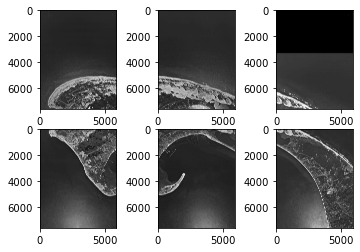

In [5]:
path_mosaic = 'data/raster/Massachusetts/'
img1 = Image.open(path_mosaic + 'O4207063.NWS.916803.tif')
img2 = Image.open(path_mosaic + 'O4207063.NES.916802.tif')
img3 = Image.open(path_mosaic + 'O4207064.NWS.916806.tif')
img4 = Image.open(path_mosaic + 'O4207063.SWS.916805.tif')
img5 = Image.open(path_mosaic + 'O4207063.SES.916804.tif')
img6 = Image.open(path_mosaic + 'O4207064.SWS.916808.tif')

f, axarr = plt.subplots(2,3)
axarr[0, 0].imshow(img1, cmap='gray')
axarr[0, 1].imshow(img2, cmap='gray')
axarr[0, 2].imshow(img3, cmap='gray')
axarr[1, 0].imshow(img4, cmap='gray')
axarr[1, 1].imshow(img5, cmap='gray')
axarr[1, 2].imshow(img6, cmap='gray')

This function computes the min and max x (eastings) and y (northing) coordinates of an image. The units are in meters.

In [6]:
def get_extent(fn):
    '''Returns min_x, max_y, max_x, min_y'''
    ds = gdal.Open(fn)
    x_min, x_resolution, x_rotation, y_max, y_rotation, y_resolution = ds.GetGeoTransform()
    x_max = x_min + x_resolution * ds.RasterXSize # RasterXSize is the length in pixels of the image in the x dimension
    y_min = y_max + y_resolution * ds.RasterYSize
    print('File {} - x_min: {} m, y_max: {} m, x_max: {} m, y_min: {} m'.format(fn, x_min, y_max, x_max, y_min))
    return (x_min, y_max, x_max, y_min)

In [7]:
os.chdir('data/raster/Massachusetts')

We compute the min and max of the mosaic image coordinates

In [8]:
in_files = glob.glob('O*.tif') # looks for files names starting with 'O' and with extension .tif
x_min, y_max, x_max, y_min = get_extent(in_files[0])
for fn in in_files[1:]:
    minx, maxy, maxx, miny = get_extent(fn)
    x_min = min(x_min, minx)
    y_max = max(y_max, maxy)
    x_max = max(x_max, maxx)
    y_min = min(y_min, miny)

print('x_min: {} m, y_max: {} m, x_max: {} m, y_min: {} m'.format(x_min, y_max, x_max, y_min))

File O4207063.NES.916802.tif - x_min: 401449.0 m, y_max: 4664648.0 m, x_max: 407356.0 m, y_min: 4657027.0 m
File O4207063.NWS.916803.tif - x_min: 396278.0 m, y_max: 4664722.0 m, x_max: 402190.0 m, y_min: 4657097.0 m
File O4207063.SES.916804.tif - x_min: 401353.0 m, y_max: 4657709.0 m, x_max: 407265.0 m, y_min: 4650088.0 m
File O4207063.SWS.916805.tif - x_min: 396177.0 m, y_max: 4657782.0 m, x_max: 402094.0 m, y_min: 4650158.0 m
File O4207064.NWS.916806.tif - x_min: 406620.0 m, y_max: 4664578.0 m, x_max: 412522.0 m, y_min: 4656961.0 m
File O4207064.SWS.916808.tif - x_min: 406529.0 m, y_max: 4657639.0 m, x_max: 412436.0 m, y_min: 4650022.0 m
x_min: 396177.0 m, y_max: 4664722.0 m, x_max: 412522.0 m, y_min: 4650022.0 m


We compute the number of pixels of the mosaic in the the x and y dimensions 

In [9]:
in_ds = gdal.Open(in_files[0])
x_offset, x_resolution, x_rotation, y_offset, y_rotation, y_resolution = in_ds.GetGeoTransform()
rows = math.ceil((y_max - y_min) / abs(y_resolution))
cols = math.ceil((x_max - x_min) / x_resolution)
print('mosaic x size: {}, y size: {}'.format(cols, rows))

mosaic x size: 16345, y size: 14700


We create a raster GeoTIFF file for the mosaic image 

In [10]:
driver = gdal.GetDriverByName('GTiff')
mosaic_ds = driver.Create('mosaic.tif', cols, rows)

In [11]:
mosaic_ds.SetProjection(in_ds.GetProjection())
mosaic_band = mosaic_ds.GetRasterBand(1)

We set the offset of the mosaic image, that is the spatial coordinates of the upper-left corner pixel 

In [12]:
mosaic_transform = [x_min, x_resolution, x_rotation, y_max, y_rotation, y_resolution]
mosaic_ds.SetGeoTransform(mosaic_transform)

0

Now we loop through all the images to copy the pixels in the mosaic image. Since the spatial reference is the same and the GeoTIFF files contain all the information required we can use a GDAL function to do the job.

In [13]:
for fn in in_files:
    in_ds = gdal.Open(fn)
    trans = gdal.Transformer(in_ds, mosaic_ds, [])
    success, xyz = trans.TransformPoint(False, 0, 0)
    x, y, z = map(int, xyz)
    data = in_ds.GetRasterBand(1).ReadAsArray()
    mosaic_band.WriteArray(data, x, y)
    in_ds = None
mosaic_ds = None

We can now plot the mosaic

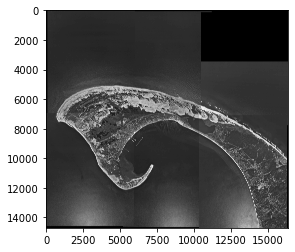

In [14]:
Image.MAX_IMAGE_PIXELS = None
mosaic_img = Image.open('mosaic.tif')
plt.imshow(mosaic_img, cmap='gray')

### Color Tables
Raster data can be used not only to record observations from a sensor, such as the reflectance of a surface, but also to assign values to areas on the Earth surface. For example the value of a pixel may represent the height at the pixel location. Another example is land use and land cover classification, in which a pixel value represents the class of an area, according to some classification criteria. In the example We use the [Switzerland](https://app.box.com/s/1cwdnolsmtf0s04o0hshbv4vxiuqcmi9/file/40585692217) dataset provided by C. Garrard. The file contains the heights in Switzerland in a very coarse scale of only 5 different values. We want to assign a color to each pixel depending on its value so that it will be possible to visualize the areas that belong to each height class. Unzip the file in a folder like in the example.

We plot the elevation model using the Python PIL package that will assign automatically a color to each value between 1 and 5 on a gray scale and black to pixels with no data. We move back to the root directory.

In [20]:
os.getcwd()
#os.chdir('../../..')

'C:\\cygwin64\\home\\Luigi\\geoscience'

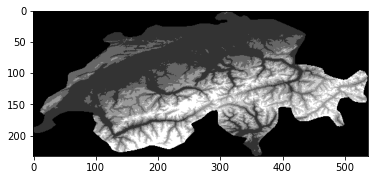

In [21]:
orig_img = Image.open('data/raster/Switzerland/dem_class.tif')
plt.imshow(orig_img, cmap='gray')

We want to assign colors that have a meaning for us. We make a copy of the file so that the original one will not be changed.

In [23]:
original_ds = gdal.Open('data/raster/Switzerland/dem_class.tif')
driver = gdal.GetDriverByName('gtiff')
ds = driver.CreateCopy('data/raster/Switzerland/dem_class2.tif', original_ds)
band = ds.GetRasterBand(1)

We create an RGB color table. One RGB color for each value, from 1 to 5, of the pixels.

In [24]:
colors = gdal.ColorTable()
colors.SetColorEntry(1, (112, 153, 89))
colors.SetColorEntry(2, (242, 238, 162))
colors.SetColorEntry(3, (242, 206, 133))
colors.SetColorEntry(4, (194, 140, 124))
colors.SetColorEntry(5, (214, 193, 156))

We set the color table of the dataset

In [25]:
band.SetRasterColorTable(colors)
band.SetRasterColorInterpretation(gdal.GCI_PaletteIndex)
band = None
ds = None

We can now plot the map with colors that represent the height at each location: green for flat land and brown for mountain areas.

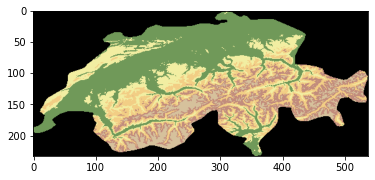

In [26]:
color_img = Image.open('data/raster/Switzerland/dem_class2.tif')
plt.imshow(color_img)

### Histograms
Histograms are used to analyze the distribution of pixel values. The GetHistogram() method of the GDAL Python binding can be used to compute a histogram of a raster file by setting the min and max pixel values, the number of buckets and other parameters.

In [27]:
#os.getcwd()
#os.chdir(r'data\Switzerland')

We set the parameters for GetHistogram() including the parameter to get an exact histogram (approx_ok=False) and to not include values out of range (include_out_of_range=False). The pixel values of the raster containing the Swiss elevation model range between 1 and 5 and we have to include the no data value that is assigned the integer value 0. So we need 7 buckets. Five buckets for each of the integer value used to represent the height, and two more buckets to represent the pixel values below or above our interval. In our example these two buckets will be empty.

In [28]:
ds = gdal.Open('data/raster/Switzerland/dem_class2.tif')
band = ds.GetRasterBand(1)
hist = band.GetHistogram(min=-0.5, max=6.5, buckets=7, include_out_of_range=False, approx_ok=False)
print('Histogram:', hist[:7], sum(hist))

Histogram: [0, 27213, 12986, 13642, 10632, 5414, 0] 69887


<BarContainer object of 7 artists>

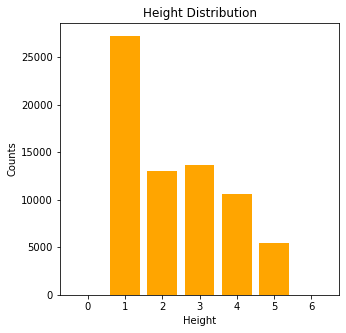

In [29]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_title("Height Distribution")
ax.set_xlabel("Height")
ax.set_ylabel("Counts");
interval = range(0, 7, 1)
plt.bar(interval, hist, color='orange')

## Map Algebra
We might want to analyse a set of raster data to answer a certain question. We might need to apply some algebric operation to that set of files. The operation will be performed using NumPy arrays and the data will be saved as raster GeoTIFF files. We will use the following function to create a GeoTIFF file from a NumPy array.

In [4]:
def make_raster(in_ds, fn, data, data_type, nodata=None):
    """Create a one-band GeoTIFF.
    in_ds: datasource to copy projection and geotransform from
    fn: path to the file to create
    data: NumPy array containing data to write
    data_type: output data type
    nodata: optional NoData value
    """
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(fn, in_ds.RasterXSize, in_ds.RasterYSize, 1, data_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_band = out_ds.GetRasterBand(1)
    if nodata is not None:
        out_band.SetNoDataValue(nodata)
    out_band.WriteArray(data)
    out_band.FlushCache()
    out_band.ComputeStatistics(False)
    return out_ds

### Local analysis
In a local analysis an algebric operator is applied to one individual pixel from each raster file in order to perform the analysis. For example to compute the value of a linear model. One example operation is the computation of the Normalized Difference Vegetation Index (NDVI) from two raster images, one containing the near-infrared (NIR) reflactance values and another containing the visible red band.

$$NDVI = \frac{NIR - RED}{NIR + RED}$$

We use a GeoTIFF file that contains the three RGB bands and a near-infrared (NIR) band. We will use only the NIR band (band 4) and the red band (band 1).

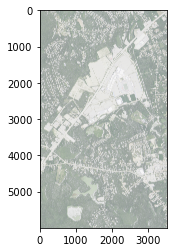

In [2]:
in_fn = 'data/raster/Massachusetts/m_4207162_ne_19_1_20140718_20140923_clip.tif'
orig_img = Image.open(in_fn)
plt.imshow(orig_img)

We compute the NDVI index for each pixel and then we store the result in a new GeoTIFF file. In case the denominator of the NDVI index is zero we will replace the index value with a constant that represents a non value. This solution allows us the complete the computation even in case of such event.

In [6]:
ndvi_fn = 'ndvi.tif'
ds = gdal.Open(in_fn)
red = ds.GetRasterBand(1).ReadAsArray().astype(float) # red band
nir = ds.GetRasterBand(4).ReadAsArray()  # NIR band
red = np.ma.masked_where(nir + red == 0, red)
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.filled(-999) * 1000 # fill the empty cells and re-scale the values
ndvi_ds = make_raster(ds, ndvi_fn, ndvi, gdal.GDT_Float32, -99)
del ds, ndvi_ds

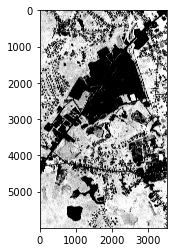

In [7]:
ndvi_img = Image.open(ndvi_fn)
plt.imshow(ndvi_img, cmap='gray')

### Focal Analysis
In a focal analysis an algebric operator is applied to the neighbors of each pixel. We might be interested in finding patterns in the raster data or we may want to fill missing values or smooth the data. One typical case is to remove the speckle in radar images. In order to accomplish any of these tasks we have to define a pixel's neighborhood and compute a function or statistics over it repeating the same operation by moving to the next pixel. The result will be a new raster data. One simple neighborhood is a square centered in a pixel, e.g. a 3x3 square. The statistics can be the mean value, the maximum value or many other. Using nested for loops to process an image is not recommended. A better approach is to create slices of the image, stack the slices in a three-dimensional array and then compute the function, e.g. sum or average. The number of slices depends on the window size. For example for a 3x3 square window 9 slices are needed.  

In [9]:
def make_slices(data, win_rows, win_cols):
    """Return a list of slices given a window size.
    data: two-dimensional array to get slices from
    win_size: tuple of (rows, columns) for the moving window
    """
    rows = data.shape[0] - win_rows + 1
    cols = data.shape[1] - win_cols + 1
    slices = []
    for i in range(win_rows):
        for j in range(win_cols):
            slices.append(data[i:rows + i, j:cols + j])
    return slices

#### Focal Analysis Example 1: smoothing a Digital Elevation Model
As an example, we use the digital elevation model (DEM) of an area around Mount Everest. We will compute a smoothed version of the DEM by averaging the pixel values in a neighborohood of 3x3 pixels. We visualize the DEM

(5010, 4505)


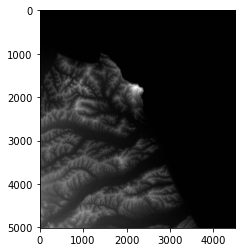

In [27]:
#path = 'data/raster/Nepal/everest.tif'
#path = '../geoscience/data/raster/italy/dem/tinitaly/w48080_s10.tif' 
path = '../geoscience/data/raster/italy/dem/tinitaly/w48085_s10.tif'
in_ds = gdal.Open(path)
in_band = in_ds.GetRasterBand(1)
in_data = in_band.ReadAsArray()
print(in_data.shape)
plt.imshow(in_data, cmap='gray')

We create the slices using the make_slices() function, then we stack them in a three-dimensional array. The slices allow us to compute the mean, max, min values by performing the corresponding operations on the slices without using for loops.

In [28]:
slices = make_slices(in_data, 3, 3)
stacked_data = np.ma.dstack(slices)
stacked_data.shape

(5008, 4503, 9)

We compute the mean value by averaging each pixel in the slices along the stack. This result is the same as averaging the values of the neighbors of each pixel.

In [29]:
rows, cols = in_band.YSize, in_band.XSize
out_data = np.ones((rows, cols), np.int32) * -99 # initialize the output to NoData (i.e.: -99)
out_data[1:-1, 1:-1] = np.mean(stacked_data, 2) # computes the mean along the stack dimension
#out_fn = r'data/raster/Nepal/everest_smoothed.tif' 
#out_fn = '../geoscience/data/raster/italy/dem/tinitaly/smooth_w48080_s10.tif'
out_fn = '../geoscience/data/raster/italy/dem/tinitaly/smooth_w48085_s10.tif'
make_raster(in_ds, out_fn, out_data, gdal.GDT_Int32, -99)
in_ds = None

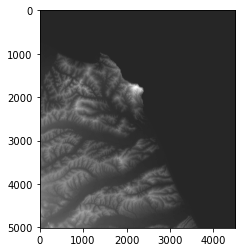

In [30]:
smoothed_ds = gdal.Open(out_fn)
smoothed_band = smoothed_ds.GetRasterBand(1)
smoothed_data = smoothed_band.ReadAsArray()
plt.imshow(smoothed_data, cmap='gray')
smoothed_ds = None

#### Focal Analysis Example 2: computing the  gradient of a Digital Elevation Model
We can use the same approach to compute the slope, i.e. the gradient, at each point of the DEM. To compute the average value of a 3x3 window around each pixel we had to compute the sum of the slices and divide by 9. We used the mean() function available in the NumPy package but that is the result. Now we use the slices to compute the DEM derivatives in the x and y directions.

$$\vec{\nabla} h(x, y) = \frac{\Delta h(x, y)}{\Delta x} \vec{i} + \frac{\Delta h(x, y)}{\Delta y} \vec{j}$$ 

The derivative of the DEM, represented by the variable h(x, y), can be computed for the direction x with the following formula

$$\frac{\Delta h(x, y)}{\Delta x} = \frac{h(x + 1, y) - h(x - 1, y)}{(x + 1) - (x - 1)} = \frac {h(x + 1, y) - h(x - 1, y)}{2}$$

We can compute the derivative in the y direction in a similar way.

In [34]:
#in_fn = r'data/raster/Nepal/everest_utm.tif'
#out_fn = r'data/raster/Nepal/everest_slope.tif'
in_fn = '../geoscience/data/raster/italy/dem/tinitaly/w48085_s10.tif'
out_fn = '../geoscience/data/raster/italy/dem/tinitaly/grad_w48085_s10.tif'
in_ds = gdal.Open(in_fn)
cell_width = in_ds.GetGeoTransform()[1]
cell_height = in_ds.GetGeoTransform()[5]
band = in_ds.GetRasterBand(1)
in_data = band.ReadAsArray().astype(np.float64)
out_data = np.ones((band.YSize, band.XSize)) * -99 # initialize the output to NoData (i.e.: -99)
slices = make_slices(in_data, 3, 3)
dem_dx = ((slices[6] + (2 * slices[7]) + slices[8]) - (slices[0] + (2 * slices[1]) + slices[2])) / (8 * cell_height)
dem_dy = ((slices[2] + (2 * slices[5]) + slices[8]) - (slices[0] + (2 * slices[3]) + slices[6])) / (8 * cell_width)
dist = np.sqrt(np.square(dem_dx) + np.square(dem_dy))
out_data[1:-1, 1:-1] = np.arctan(dist) * 180 / np.pi
make_raster(in_ds, out_fn, out_data, gdal.GDT_Float32, -99)
in_ds = None

We can now plot the slope, the gradient of the digital elevation model 

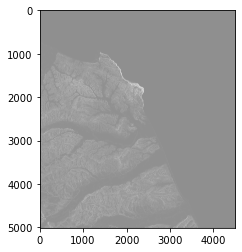

In [35]:
slope_ds = gdal.Open(out_fn)
slope_band = slope_ds.GetRasterBand(1)
slope_array = slope_band.ReadAsArray()
plt.imshow(slope_array, cmap='gray')
slope_ds = None

We can also use [SciPy](https://scipy.github.io/devdocs/tutorial/ndimage.html) to apply different filters to a raster file. For example we can apply a smoothing filter (uniform_filter() in SciPy) to the DEM of Mount Everest  

In [39]:
import scipy.ndimage
#in_fn = 'data/raster/Nepal/everest.tif'
#out_fn = r'data/raster/Nepal/everest_smoothed.tif'
in_fn = '../geoscience/data/raster/italy/dem/tinitaly/w48085_s10.tif'
out_fn = '../geoscience/data/raster/italy/dem/tinitaly/scipy_smooth_w48085_s10.tif'
in_ds = gdal.Open(in_fn)
in_data = in_ds.GetRasterBand(1).ReadAsArray()
out_data = scipy.ndimage.uniform_filter(in_data, size=3, mode='nearest')
make_raster(in_ds, out_fn, out_data, gdal.GDT_Int32)
in_ds = None

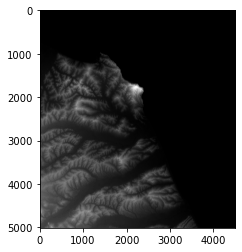

In [40]:
smoothed_ds = gdal.Open(out_fn)
smoothed_band = smoothed_ds.GetRasterBand(1)
smoothed_data = smoothed_band.ReadAsArray()
plt.imshow(smoothed_data, cmap='gray')
smoothed_ds = None

### Zonal Analysis
A zone is a collection of pixels with the same value, for example to represents the land cover categories or areas at risk of floods or landslides. We might want to find out the areas used for agriculture or forested, or that are occupied by water bodies that belong to some administrative regions. Zonal analysis is based on zonal functions that can be performed using one or two raster images. An example of zonal operation with one input file is the measure of the area of the zones. With two input raster files one file defines the zones while the second file provides the values to be used within those zones. For example we might want to know what are the areas of some administrative regions that are classified according to a set of classes of land cover, e.g. forest, crop, water body, urban. The administrative regions and the land cover are provided as raster files. For the land cover each pixel is assigned a value that represents the class, e.g. forest, crops, urban. We want to find out how many square kilometers are classified according to one of the classes within each administrative region. We could represent the result with a histogram where each bar represents one class and its height represents the size of the area. If there are more than one zone, e.g. more than one administrative regions, we will compute the areas for each class and region.  

In [114]:
landcover_fn = 'data/raster/Utah/landcover60.tif'  # land cover
ecoregion_fn = 'data/raster/Utah/utah_ecoIII60.tif' # raster file of the eco regions

We need to know the set of values used to represent the classes of land cover. The classes will be used as bins for the histogram. We have to do the same for the set of values of the administrative regions, or zones. The set of values of the zones will be used as bins for the regions in the histogram. For each region we will have a bar made up of the bins of the land cover for that region. We define a function to create the bins.

In [5]:
def get_bins(data):
    """Return bin edges for all unique values in data."""
    bins = np.unique(data)
    return np.append(bins, max(bins) + 1)

We open the dataset that defines the eco regions, our zones of interest, and create its bins

In [6]:
eco_ds = gdal.Open(ecoregion_fn)
eco_band = eco_ds.GetRasterBand(1)
eco_data = eco_band.ReadAsArray()
eco_bins = get_bins(eco_data)
eco_bins

array([  1,   2,   3,   4,   5,   6,   7, 255, 256])

In the plot we have to set the minimum and maximum values to be used for the color range otherwise most of the pixel will be shown as black (lower values) and the rest white (255, 256).

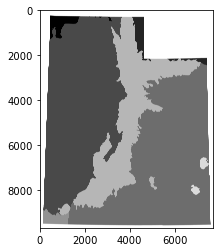

In [29]:
plt.imshow(eco_data_class, cmap='gray', vmin=1, vmax=8)

We can reclassify the pixels changing those with value 255 or 255 using the index of the bins to which each value in input raster file belongs.

In [44]:
eco_data_class = np.digitize(eco_data, eco_bins)
print(np.unique(eco_data_class))

[1 2 3 4 5 6 7 9]


In [45]:
eco_bins = get_bins(eco_data_class)
eco_bins

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10], dtype=int64)

In [46]:
eco_buckets = int(len(eco_bins))
eco_buckets

9

In [47]:
eco_min = int(min(eco_bins))
eco_min

1

In [48]:
eco_max = int(max(eco_bins))
eco_max

10

We create the histogram of the regions by counting the number of values that fall in the bins

In [41]:
hist = eco_band.GetHistogram(min=eco_min, max=eco_max, buckets=eco_buckets, include_out_of_range=False, approx_ok=False)
print('Histogram:', hist, sum(hist))

Histogram: [721558, 818240, 22853446, 23777724, 541935, 12082162, 262829, 0, 0] 61057894


<BarContainer object of 9 artists>

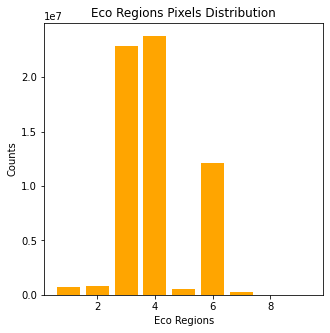

In [43]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_title("Eco Regions Pixels Distribution")
ax.set_xlabel("Eco Regions")
ax.set_ylabel("Counts");
interval = range(eco_min, eco_buckets + 1, 1)
plt.bar(interval, hist, color='orange')

Then we open the dataset about the land cover and create the bins, the set of values used in the land cover raster file.

In [49]:
lc_ds = gdal.Open(landcover_fn)
lc_band = lc_ds.GetRasterBand(1)
lc_data = lc_band.ReadAsArray()
lc_bins = get_bins(lc_data)
lc_bins

array([  0,   1,   2,   4,   5,   8,   9,  10,  11,  12,  13,  14,  15,
        18,  19,  21,  22,  23,  24,  25,  26,  28,  29,  30,  32,  34,
        36,  37,  38,  39,  40,  41,  42,  44,  46,  47,  48,  49,  50,
        51,  53,  54,  58,  60,  61,  62,  64,  66,  67,  69,  70,  71,
        76,  77,  78,  79,  80,  82,  83,  84,  85,  86,  94,  98, 104,
       108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122,
       123, 124, 125, 126])

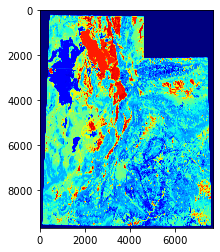

In [53]:
plt.imshow(lc_data, cmap='jet')

In [54]:
lc_buckets = int(len(lc_bins))
lc_buckets

82

In [55]:
lc_min = int(min(lc_bins))
lc_min

0

In [57]:
lc_max = int(max(lc_bins))
lc_max

126

In [58]:
hist = lc_band.GetHistogram(min=lc_min, max=lc_max, buckets=lc_buckets, include_out_of_range=False, approx_ok=False)
print('Histogram:', hist, sum(hist))

Histogram: [12493056, 226448, 49015, 409664, 0, 4105031, 510070, 603442, 138, 3187869, 0, 2885, 3366, 1551, 2016270, 11087, 908243, 0, 869856, 477013, 398220, 0, 569902, 6337825, 3479037, 30308, 2689702, 75403, 177610, 2654478, 28, 6740109, 422621, 166214, 2580221, 239926, 0, 4387066, 0, 269267, 3981874, 2652, 156734, 2338334, 81422, 138676, 165492, 0, 0, 575844, 86244, 235727, 5649, 2049870, 3428, 265610, 0, 0, 0, 0, 0, 798, 0, 82913, 0, 0, 0, 1433, 0, 0, 245172, 1887147, 868933, 12829, 2626323, 48179, 175869, 147174, 908719, 194257, 212938, 14521] 74607702


<BarContainer object of 82 artists>

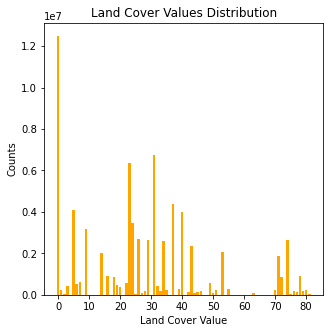

In [60]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.set_title("Land Cover Values Distribution")
ax.set_xlabel("Land Cover Value")
ax.set_ylabel("Counts");
interval = range(lc_min, lc_buckets, 1)
plt.bar(interval, hist, color='orange')

Now we want to visualize how the different types of land covers are distributed in the eco regions. For this purpose we compute the histogram of the land cover for each eco region.

In [87]:
hist, zone_bins, landcover_bins = np.histogram2d(eco_data_class.flatten(), lc_data.flatten(), [eco_bins, lc_bins])

We define a function to plot the histogram

In [115]:
def plot_histogram(hist, bins):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    ax.set_title("Ecoregions per land cover")
    ax.set_xlabel("Landcover")
    plt.bar(bins[:-1], hist[0], color='blue')
    plt.bar(bins[:-1], hist[1], color='orange')
    plt.bar(bins[:-1], hist[2], color='green')
    plt.bar(bins[:-1], hist[3], color='purple')
    plt.bar(bins[:-1], hist[4], color='pink')
    plt.bar(bins[:-1], hist[5], color='olive')
    plt.bar(bins[:-1], hist[6], color='red')
    plt.bar(bins[:-1], hist[7], color='cyan')

We remove the eco region 0 from the plot.

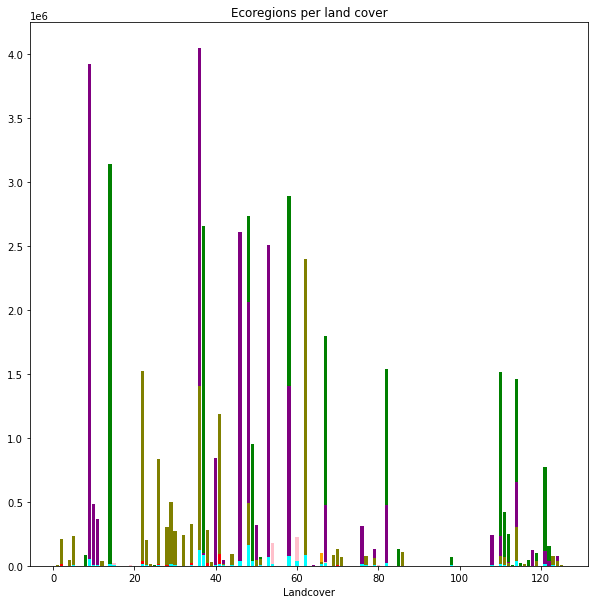

In [116]:
plot_histogram(hist[:, 1:], landcover_bins[1:])

Finally we save the histogram on a CSV file

In [113]:
out_fn = 'data/raster/Utah/histogram.csv'
np.savetxt(out_fn, hist, fmt='%1.0f', delimiter=',')

### Global Analysis
The output of a global analysis is a function of all the input raster data. An example is the cost allocation (or distance) of traveling from a source cell. The cost associated to travel from a source cell to any other cell on a flat surface can be calculated using the Euclidean distance for each cell. In case the surface is not flat the cost will be different, depending on the elevation of the cell. As an example we use a vector dataset containing wilderness areas in Idaho and other areas in the US and another vector dataset contaning all the Idaho roads. We are interested in calculating the shorter distance to a road from each cell in a wilderness area of Idaho. This type of analysis is called proximity analysis. The first step to start the computation of the distances is to convert the roads vector data into raster. The conversion is calles 'rasterization'. 

In [16]:
folder = 'data/raster/Idaho/'
allroads_ln = folder + 'allroads.shp' # vector dataset containing the roads of Idaho
wilderness_ln = folder + 'wilderness.shp' # vector dataset of wilderness in a larger area of the US

Get the extent of the wilderness area by selecting the records with WILD_NM = 'Frank Church - RONR' and computing the bounding box that contains the area.

In [17]:
wild_ds = ogr.Open(wilderness_ln)
wild_lyr = wild_ds.GetLayerByName('wilderness')
print(wild_lyr.GetSpatialRef())

PROJCS["Custom",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",42],
    PARAMETER["central_meridian",-114],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",2500000],
    PARAMETER["false_northing",1200000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]


In [18]:
wild_lyr.SetAttributeFilter("WILD_NM = 'Frank Church - RONR'")
envelopes = [row.geometry().GetEnvelope() for row in wild_lyr]
coords = list(zip(*envelopes))
min_x, max_x = min(coords[0]), max(coords[1])
min_y, max_y = min(coords[2]), max(coords[3])
print(min_x, max_x, min_y, max_y)

2347778.078370039 2470558.146773548 1467254.3027636106 1615295.5238143115


We select the roads in Idaho that lie within the bounding box that contains the wilderness area

In [19]:
allroads_ds = ogr.Open(allroads_ln)
allroads_lyr = allroads_ds.GetLayerByName('allroads')
allroads_lyr.SetSpatialFilterRect(min_x, min_y, max_x, max_y)

Compute the number of rows and colums needed for the raster

In [20]:
tif_driver = gdal.GetDriverByName('GTiff')
cellsize = 10
cols = int((max_x - min_x) / cellsize)
rows = int((max_y - min_y) / cellsize)
rows, cols

(14804, 12278)

We create an empty raster file for roads in the selected bounding box

In [21]:
road_raster_fn = folder + 'church_roads.tif'
road_ds = tif_driver.Create(road_raster_fn, cols, rows)
road_ds.SetProjection(allroads_lyr.GetSpatialRef().ExportToWkt())
road_ds.SetGeoTransform((min_x, cellsize, 0, max_y, 0, -cellsize))
#print(road_ds.GetSpatialRef())
print(road_ds.GetProjection())

PROJCS["NAD_1983_Transverse_Mercator",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",42],PARAMETER["central_meridian",-114],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",2500000],PARAMETER["false_northing",1200000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Now we burn (write) the roads in the selected bounding box into a raster

In [23]:
bands = [1]
gdal.RasterizeLayer(road_ds, bands, allroads_lyr) #, burn_values=[1]) #, callback=gdal.TermProgress)

0

We compute the proximity to a road of any cell in the wilderness area and store the result in a new raster file

In [24]:
proximity_fn = folder + 'proximity.tif'
prox_ds = tif_driver.Create(proximity_fn, cols, rows, 1, gdal.GDT_Int32)
prox_ds.SetProjection(road_ds.GetProjection())
prox_ds.SetGeoTransform(road_ds.GetGeoTransform())

0

In [25]:
gdal.ComputeProximity(road_ds.GetRasterBand(1), prox_ds.GetRasterBand(1), ['DISTUNITS=GEO'])#, gdal.TermProgress)

0

We Write the data of the roads within the bounding box and the proximity and set NoData outside

In [26]:
road_ds.GetRasterBand(1).SetNoDataValue(-99)
road_ds.FlushCache()

In [27]:
prox_ds.GetRasterBand(1).SetNoDataValue(-99)
prox_ds.FlushCache()

We plot the proximity data, white areas are farer from the roads

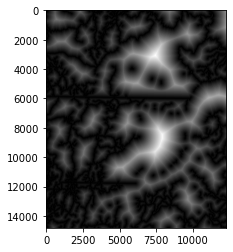

In [29]:
prox_band = prox_ds.GetRasterBand(1)
prox_data = prox_band.ReadAsArray()
plt.imshow(prox_data, cmap='gray')

We compute the mean distance from the roads

In [30]:
stats = prox_ds.GetRasterBand(1).ComputeStatistics(False) #, gdal.TermProgress)
print('Mean distance from roads is ', stats[2])

Mean distance from roads is {0:f.1} 2822.8757695672944


Finally we close the datasets

In [31]:
del wild_ds, allroads_ds, road_ds, prox_ds, 

### Resampling data
Resampling a raster dataset, to a finer or larger resolution, is done automatically while reading the file using the ReadAsArray() function when the output buffer is different from that of the input raster. The algorithm used by the ReadAsArray() function for resampling is nearest-neighbor for which an average value among each pixel's nearest neighbors is computed and used to create a smoothed version of the original image. The nearest-neighbors algorithms is commonly used for categorical data. For data that represent continuous values, such as elevation or any physical parameter, other algorithms, such as bilinear interpolation and cubic convolution are used.

#### Slicing

In [2]:
def make_resample_slices(data, win_size):
    """Return a list of resampled slices given a window size.
       data - two-dimensional array to get slices from
       win_size - tuple of (rows, columns) for the input window
    """
    row = int(data.shape[0] / win_size[0]) * win_size[0]
    col = int(data.shape[1] / win_size[1]) * win_size[1]
    slices = []
    for i in range(win_size[0]):
        for j in range(win_size[1]):
            slices.append(data[i:row:win_size[0], j:col:win_size[1]])
    return slices

Let's create the slices for a small 2D array to see how it works

In [3]:
data_tpl = [[3, 5, 6, 4, 4, 3],
        [4, 5, 8, 9, 6, 5],
        [2, 2, 5, 7, 6, 4],
        [5, 7, 9, 8, 9, 7],
        [4, 6, 5, 7, 7, 5],
        [3, 2, 5, 3, 4, 4]]
data = array = np.array(data_tpl)

In [4]:
slices = make_resample_slices(data, (2, 2))
slices

[array([[3, 6, 4],
        [2, 5, 6],
        [4, 5, 7]]),
 array([[5, 4, 3],
        [2, 7, 4],
        [6, 7, 5]]),
 array([[4, 8, 6],
        [5, 9, 9],
        [3, 5, 4]]),
 array([[5, 9, 5],
        [7, 8, 7],
        [2, 3, 4]])]

In [5]:
sum(slices) / 4

array([[4.25, 6.75, 4.5 ],
       [4.  , 7.25, 6.5 ],
       [3.75, 5.  , 5.  ]])

Now we apply the method to a real raster file

(5010, 4505)


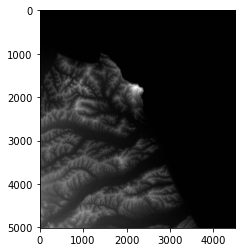

In [6]:
path = 'data/raster/italy/dem/tinitaly/w48085_s10.tif'
in_ds = gdal.Open(path)
in_band = in_ds.GetRasterBand(1)
in_data = in_band.ReadAsArray()
print(in_data.shape)
plt.imshow(in_data, cmap='gray')

We compute the slices using a 2x2 window that will result in a list of 4 slices

In [7]:
slices = make_resample_slices(in_data, (2, 2))
len(slices)

4

We compute the mean value by adding the values of corresponding pixels in the four slices

In [8]:
resampled_data = sum(slices) / 4
resampled_data.shape

(2505, 2252)

In [9]:
out_rows = round(in_band.YSize / 2)
out_columns = round(in_band.XSize / 2)
out_rows, out_columns

(2505, 2252)

We create a new GeoTIFF file to store the resampled image

In [10]:
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create('data/raster/italy/dem/tinitaly/resampled_w48085_s10.tif', out_columns, out_rows)

We print the pixel resolution of the source file 

In [17]:
geotransform = list(in_ds.GetGeoTransform())
print('Pixel resolution\nWest-East direction: {} m.\nNorth-South direction: {} m.'.format(geotransform [1], abs(geotransform [5])))

Pixel resolution
West-East direction: 10.0 m.
North-South direction: 10.0 m.


After the smoothing process the pixel resolution is halved, that is it's 20.0 m. in both directions

In [18]:
out_ds.SetProjection(in_ds.GetProjection())
geotransform = list(in_ds.GetGeoTransform())
geotransform [1] *= 2  # west-east pixel resolution (or pixel width)
geotransform [5] *= 2  # north-south pixel resolution
out_ds.SetGeoTransform(geotransform)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(resampled_data)
out_band.FlushCache()
out_band.ComputeStatistics(False)
out_ds.BuildOverviews('average', [2, 4, 8, 16, 32, 64])

0

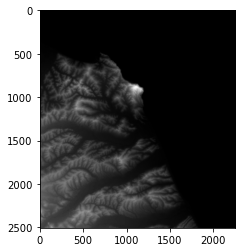

In [19]:
plt.imshow(resampled_data, cmap='gray')

#### Bilinear interpolation
If we want to rescale an image with a scale factor that is not an integer we cannot simply use the slicing algorithm. A choice is to use [bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation). The algorithm uses the four nearest cell centers. It can be implemented as two functions. The first function computes the indices for the cells of the resampled raster, and the second function computes the value from the values of the four nearest neighbors. 

In [2]:
def get_indices(source_ds, target_width, target_height):
    """Returns x, y lists of all possible resampling offsets.
    source_ds - dataset to get offsets from
    target_width - target pixel width
    target_height - target pixel height (negative)
    """
    source_geotransform = source_ds.GetGeoTransform()
    source_width = source_geotransform[1]
    source_height = source_geotransform[5]
    dx = target_width / source_width
    dy = target_height / source_height
    target_x = np.arange(dx / 2, source_ds.RasterXSize, dx)
    target_y = np.arange(dy / 2, source_ds.RasterYSize, dy)
    return np.meshgrid(target_x, target_y)

The 2nd function computes the cell values by interpolating 4 nearest cells in the original raster

In [3]:
def bilinear(in_data, x, y):
    """Performs bilinear interpolation.
    in_data - the input dataset to be resampled
    x - an array of x coordinates for output pixel centers
    y - an array of y coordinates for output pixel centers
    """
    x -= 0.5
    y -= 0.5
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    ul = in_data[y0, x0] * (y1 - y) * (x1 - x)
    ur = in_data[y0, x1] * (y1 - y) * (x - x0)
    ll = in_data[y1, x0] * (y - y0) * (x1 - x)
    lr = in_data[y1, x1] * (y - y0) * (x - x0)
    return ul + ur + ll + lr

We open an example raster file

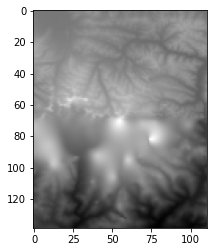

In [4]:
in_fn = 'data/raster/Nepal/everest.tif'
in_ds = gdal.Open(in_fn)
in_band = in_ds.GetRasterBand(1)
in_data = in_band.ReadAsArray()
plt.imshow(in_data, cmap='gray')

We compute the coordinates of the output raster file by passing the factor to be used for the transformation along the two directions west-east and north-south. With the new coordinates we can apply the nearest neighbor algorithm to compute the values of the output raster file.

In [5]:
cell_size = (0.02, -0.02)
x, y = get_indices(in_ds, *cell_size)
outdata = bilinear(in_ds.ReadAsArray(), x, y)

We create the output file to store the result

In [6]:
out_fn = 'data/raster/Nepal/everest_bilinear.tif'
driver = gdal.GetDriverByName('GTiff')
rows, cols = outdata.shape
out_ds = driver.Create(out_fn, cols, rows, 1, gdal.GDT_Int32)
out_ds.SetProjection(in_ds.GetProjection())

0

In [7]:
gt = list(in_ds.GetGeoTransform())
gt[1] = cell_size[0]
gt[5] = cell_size[1]
out_ds.SetGeoTransform(gt)

0

In [8]:
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(outdata)
out_band.FlushCache()
out_band.ComputeStatistics(False)

[584.0, 8454.0, 4515.728635682175, 1371.0860010092429]

Finally we plot the output file

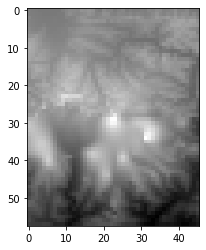

In [9]:
#out_ds = gdal.Open(out_fn)
#out_band = out_ds.GetRasterBand(1)
out_data = out_band.ReadAsArray()
plt.imshow(out_data, cmap='gray')

GDAL provides the gdalwarp command-line utility for resampling raster data using different algorithms. 

## References
1. [GDAL Geotransform Tutorial](https://gdal.org/tutorials/geotransforms_tut.html)
2. [Richards- Remote Sensing Digital Image Analysis, 5th Ed.](https://www.amazon.com/Remote-Sensing-Digital-Image-Analysis/dp/3642300618)
3. [Lillesand - Remote Sensing and Image Interpretation, 7th Ed.](https://www.amazon.com/Remote-Sensing-Interpretation-Thomas-Lillesand/dp/111834328X/)
4. [Ruescas, Peters - SNAP S3TBX Collocation Tutorial](https://step.esa.int/docs/tutorials/Collocation_S3TBX_Tutorial_v1_rev6.pdf)